## This notebook demonstrates how to use the augment module. It uses the `strw_lofar_data_utils` package to create cutouts from DR2 Mosaics on the STRW cluster. This notebook is meant to demonstrate the core capabilities of said module.

# Import necessary libraries and modules:

In [1]:
import sys
import pandas as pd
import os
from copy import deepcopy

sys.path.append('/home/penchev/strw_lofar_data_utils/')
from src.pipelines import generate_cutouts

# Load a catalogue from which we will extract the RA and Dec for cutout generation:

In [2]:
GIANTS_CATALOG = "/home/penchev/strw_lofar_data_utils" + "/data/discovered_giants_catalogue.csv"
GIANTS_CATALOG

'/home/penchev/strw_lofar_data_utils/data/discovered_giants_catalogue.csv'

In [3]:
giants_df = pd.read_csv(GIANTS_CATALOG)
giants_df.head()

,recno,Name,RAJ2000,DEJ2000,LengthMpc,e_LengthMpc,LengthAng,z,e_z,Ref,FistDisc
0,10511,NaN,40.275764,8.737979,0.871,0.008,32.70,0.02121,0.00017,Oei et al. 2023,Oei et al. 2023
1,10358,NaN,38.802856,10.196330,1.014,0.607,15.60,0.05384,0.00000,Oei et al. 2023,Oei et al. 2023
2,10283,NaN,48.697044,15.149883,1.067,0.505,12.70,0.07104,0.00000,Oei et al. 2023,Oei et al. 2023
3,10938,NaN,42.945000,15.836940,0.918,0.000,2.46,0.48900,0.00000,Mahato et al. 2021,Mahato et al. 2021
4,10055,NaN,43.804028,17.514114,1.295,0.441,11.60,0.09725,0.00000,Oei et al. 2023,Oei et al. 2023


# Extract RA and Dec from the catalogue to define cutout regions:

In [4]:
# Get RA and DEC for the first 100 giants
ra_dec_list = list(
    zip(giants_df["RAJ2000"].values, giants_df["DEJ2000"].values)
)
ra_dec_list = ra_dec_list[:100] # Chose only first 100

print(ra_dec_list[:5])

[(40.275764, 8.737979), (38.802856, 10.19633), (48.697044, 15.149883), (42.945, 15.83694), (43.804028, 17.514114)]


# Generate cutouts using the defined RA and Dec coordinates:

In [5]:
cutouts = generate_cutouts(
    ra_dec_list=ra_dec_list,
    size_pixels = 300,
    save=False
)

Generating cutouts:  10%|█         | 10/100 [00:00<00:01, 76.88it/s]

No mosaic found covering RA: 40.275764, Dec: 8.737979
No mosaic found covering RA: 38.802856, Dec: 10.19633
No mosaic found covering RA: 48.697044, Dec: 15.149883
No mosaic found covering RA: 42.945, Dec: 15.83694
No mosaic found covering RA: 43.804028, Dec: 17.514114
No mosaic found covering RA: 60.128278, Dec: 13.156841
No mosaic found covering RA: 59.031086, Dec: 13.819252
No mosaic found covering RA: 48.748005, Dec: 16.180998
No mosaic found covering RA: 50.35795833333, Dec: 18.10273333333
No mosaic found covering RA: 40.5115004251, Dec: 16.11821193104
No mosaic found covering RA: 41.28541529943, Dec: 18.70481428751
No mosaic found covering RA: 37.090862, Dec: 17.773199


Generating cutouts: 100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


In [6]:
print(f"Generated {len(cutouts)} cutouts.")

Generated 88 cutouts.


# Chose an example cutout to work with:

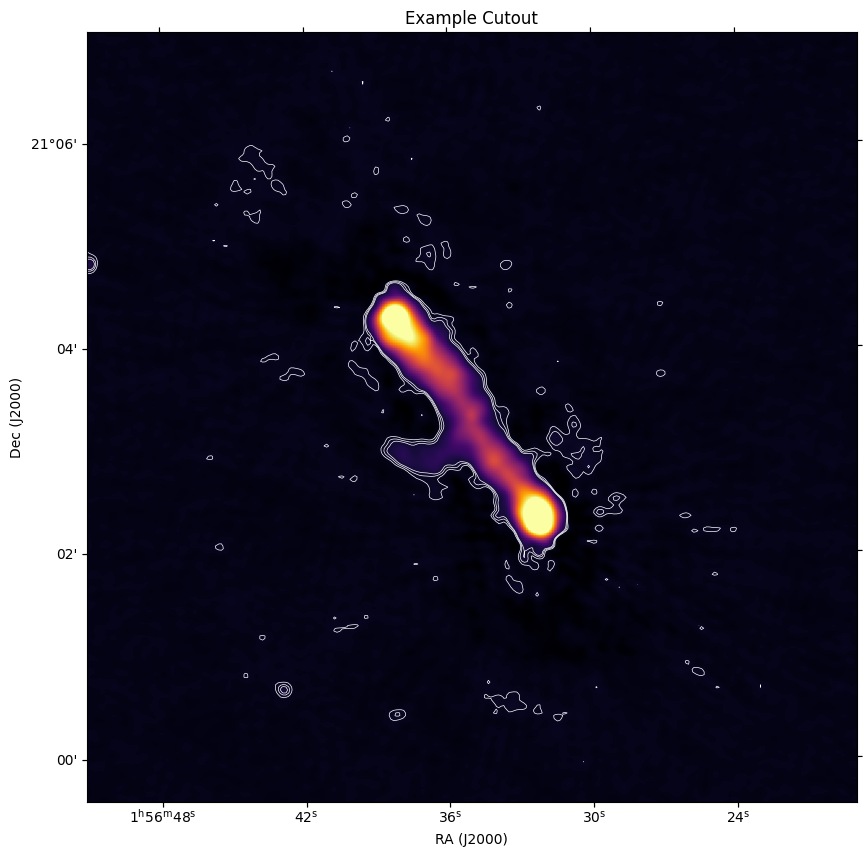

In [10]:
example_cutout = cutouts[65]

example_cutout.show_cutout(
    title="Example Cutout",
    contour_levels=[5, 10, 15]
)

# The augment module can be used to create augmented versions of the cutout.

# The first augment we can do is rotate the image by an arbitrary angle:

In [23]:
sys.path.append('/home/penchev/astro-datatools/')
from astro_datatools.augment.rotate import RotateAugment

# Define the angles
angles = [0, 45, 90, 135, 180, 225, 270, 315]

# Get the cutout data
data_to_rotate = deepcopy(example_cutout.get_data())

# Create rotatator
rotator = RotateAugment(
    angles=angles,
    height_and_width_axes=(-2, -1), # Here we assume that no mater if it is batched, channeld or whathever, the last two axes are height and width in this order.
    dynamic_cropping=True, # Whether to crop dynamically based on rotation.
    specific_crop_size=None # No specific crop size
)

rotated_data = rotator.augment(data_to_rotate)

print(f"Original shape: {data_to_rotate.shape}")
print(f"Rotated data shape: {rotated_data.shape}")

Original shape: (300, 300)
Rotated data shape: (8, 212, 212)


We can see that now we have 8 augmented versions of the original cutout. The largest possible rectangle without black borders is computed to be 212x212 pixels.
This corresponds to a rotation of 45 degrees. Now let's visualize the rotated cutouts:

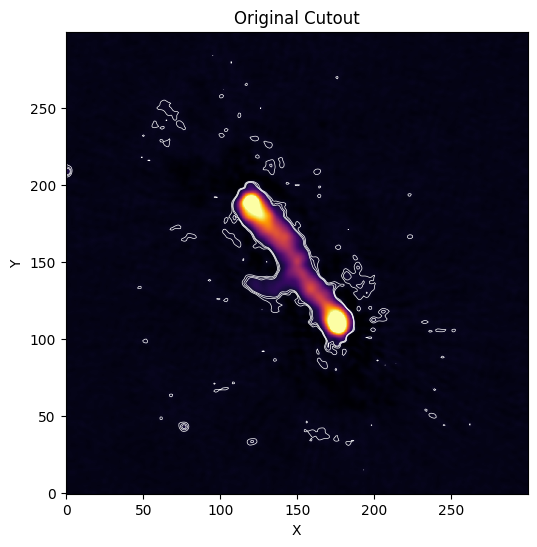

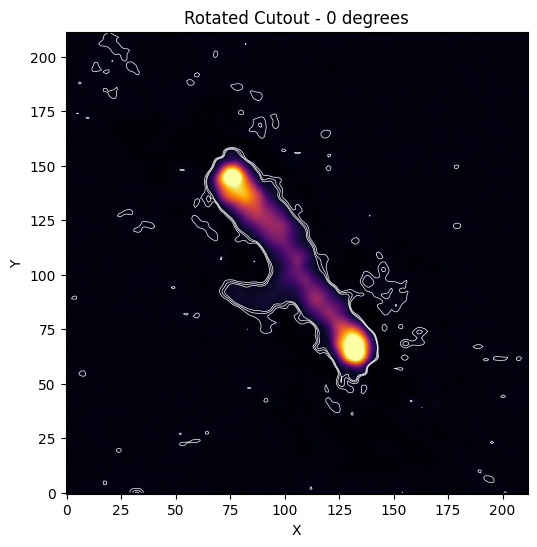

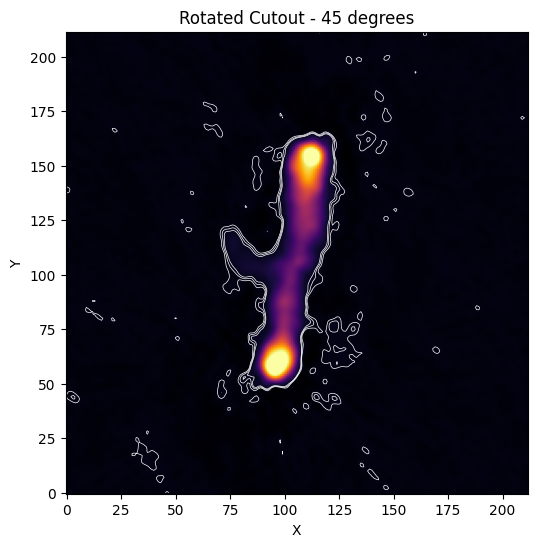

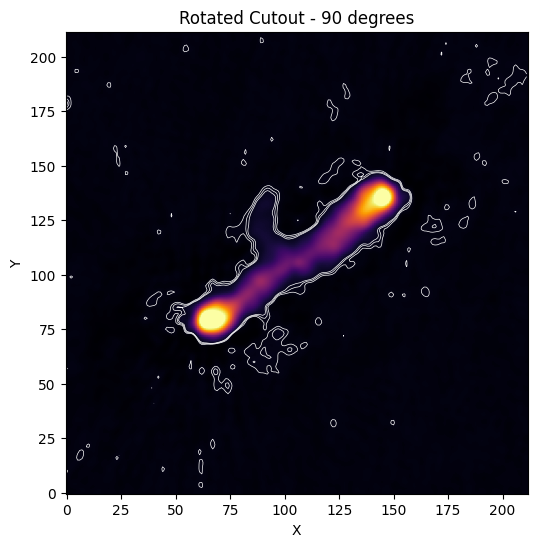

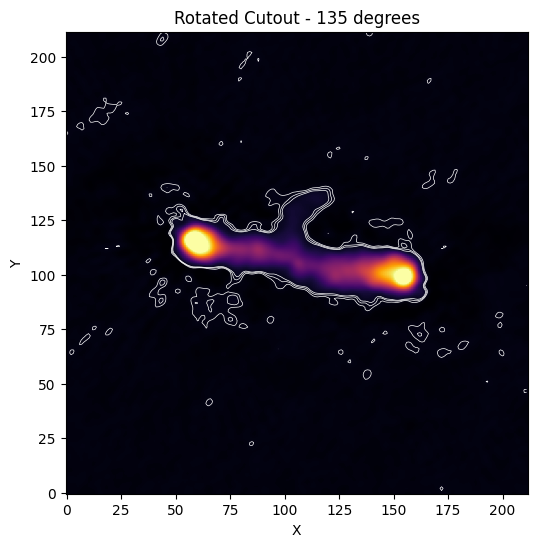

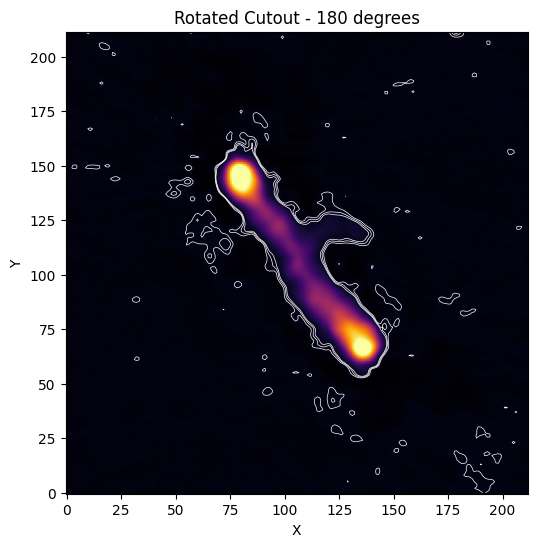

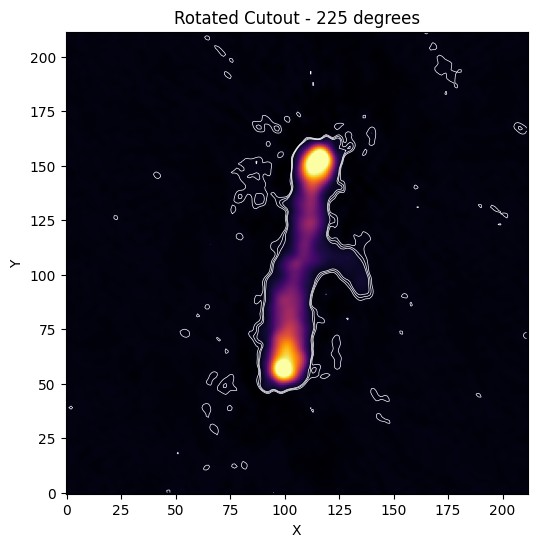

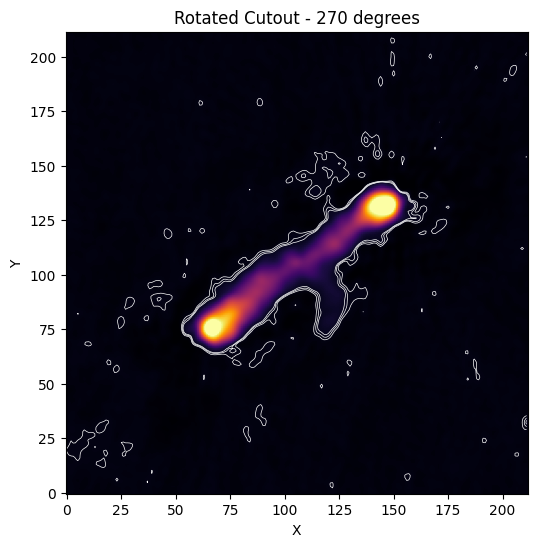

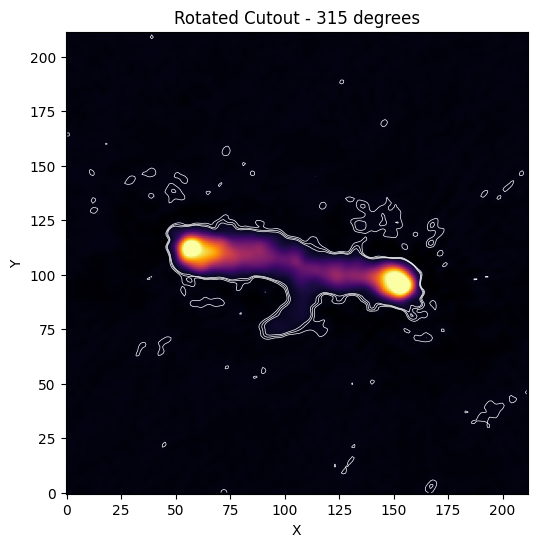

In [25]:
from astropy.visualization import AsinhStretch, ImageNormalize, PercentileInterval
import matplotlib.pyplot as plt
import numpy as np


def show_cutout(data: np.ndarray, title: str, contour_levels: list = None, cmap='inferno', rms = 0.1*1e-3) -> None:
        """
        Show the cutout using matplotlib.
        """
        def _make_contour_levels(levels: list):
            """
            Generates contour levels based on RMS noise.
            
            :param levels: List of contour levels in multiples of RMS noise
            :return: List of contour levels in Jy/beam
            """
            return np.array(levels) * rms  # Convert mJy/beam to Jy/beam
        
        contour_levels = _make_contour_levels(contour_levels) if contour_levels is not None else None

        norm = ImageNormalize(data, interval=PercentileInterval(99.5), stretch=AsinhStretch())
        _, ax = plt.subplots(figsize=(6, 6))
        _ = ax.imshow(data, cmap=cmap, origin='lower', norm=norm)
        ax.contour(data, levels=contour_levels, colors='white', linewidths=0.5)
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.show()
        plt.close()

def visualize_rotated_cutouts(original_data, rotated_data, angles):
    """
    Visualize the original and rotated cutouts.
    """
    show_cutout(original_data, title="Original Cutout", contour_levels=[5, 10, 15])

    for i, angle in enumerate(angles):
        show_cutout(rotated_data[i], title=f"Rotated Cutout - {angle} degrees", contour_levels=[5, 10, 15])

visualize_rotated_cutouts(data_to_rotate, rotated_data, angles)

# The second augment we are going to look at is creating a so called RGB (Red-Green-Blue) image from the original single channel image.
# The procedure is as follows:
In the first channel:

    - square-root stretched between 1 and 30 sigma

In the second channel:

    - all radio emission above three sigma are set to one while all radio emission below that value to zero.

In the third channel:

    - all radio emissions above five sigma are set to one and all radio emission below that value to zero.

Encoding schema adopted from: "Radio source-component association for the LOFAR Two-metre
Sky Survey with region-based convolutional neural networks" by Mostert et al. (2022) doi: https://doi.org/10.1051/0004-6361/202243478

In [26]:
from astro_datatools.augment.lotss_to_rgb import LotssToRGBAugment

# Extract cutout data as np.ndarray
cutout_data = example_cutout.get_data()

# Defining the RMS
RMS = 0.1 * 1e-3  # Jy/beam

# Set asinh_stretch to False for square root stretch to keep consistenct with Mostert et al. (2022)
rgb_augmenter = LotssToRGBAugment(rms_noise=RMS, asinh_stretch=False)

rgb_image = rgb_augmenter.augment(cutout_data) # Here we get the RGB image in ndarray format with shape (C, H, W), where C=3, H=300, W=300

# Now we can show the RGB image:

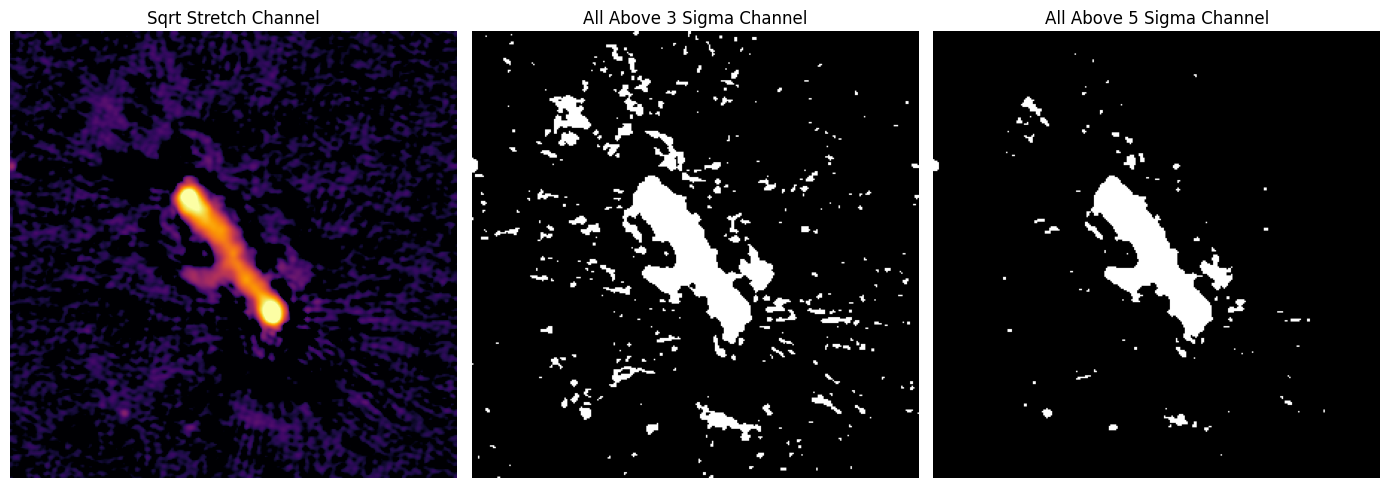

In [28]:
def show_rgb_image(rgb_image):
    """Plot 3 different channels as separate images"""
    _, ax = plt.subplots(1, 3, figsize=(14, 14))

    # Separate the channels for clarity
    sqrt_stretch_channel = rgb_image[0, :, :]
    all_above_3_sigma_channel = rgb_image[1, :, :]
    all_above_5_sigma_channel = rgb_image[2, :, :]

    # Creating a normalization for better visualization of the sqrt stretch channel
    norm = ImageNormalize(sqrt_stretch_channel, interval=PercentileInterval(99.5), stretch=AsinhStretch())
    
    ax[0].imshow(sqrt_stretch_channel, cmap='inferno', origin='lower', norm=norm)
    ax[0].set_title("Sqrt Stretch Channel")
    ax[0].axis('off')

    ax[1].imshow(all_above_3_sigma_channel, cmap='gray', origin='lower')
    ax[1].set_title("All Above 3 Sigma Channel")
    ax[1].axis('off')

    ax[2].imshow(all_above_5_sigma_channel, cmap='gray', origin='lower')
    ax[2].set_title("All Above 5 Sigma Channel")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

show_rgb_image(rgb_image)